Remeber to set RunTime type to GPU/TPU before u start



In [ ]:
#import necessary packages

import csv
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import torch

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#helper functions with tokenizing and cleaning up

import re  

#tokenizes a list of sentences: [str, str, str] --> [[str,str, str],[str, str, str], [str, str, str]]
def tokenize_list(l, tokenizer = lambda s: s.split()):
  output = list()
  for i in l:
    #print(tokenizer(i))
    output.append(tokenizer(i))
  return output

#removes any punctuations
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        #remove punctuation
        text = re.sub('[^a-zA-Z0-9.]', ' ', text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        text = text.lower()
        # remove "Reuters" keyword
        text = re.sub(r'reuters', ' ', text)
        #remove "video" keyword
        text = re.sub(r'video', ' ', text)
        cleaned_text.append(text)
    return cleaned_text

In [ ]:
#glove_loader
def load_glove_embeddings(file_path: str) -> "dict[str, np.ndarray]":
    """
    Loads trained GloVe embeddings downloaded from:
        https://nlp.stanford.edu/projects/glove/
    """
    word_to_embedding = {}
    with open(file_path, "r") as f:
        for line in f:
            word, raw_embeddings = line.split()[0], line.split()[1:]
            embedding = np.array(raw_embeddings, dtype=np.float64)
            word_to_embedding[word] = embedding
    return word_to_embedding

In [ ]:
#loading data ... text_title concatenated with text_content
#scripts to load the ISOT data, X_total is a concatenation of X_real and X_fake, Y_total similar idea

with open('/content/gdrive/MyDrive/COMP 599 Project/Fake.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  
  X_fake = []
  Y_fake = []
  for row in csv_reader: 
      X_fake.append(row[0]+ " " + row[1])
      Y_fake.append(1)

with open('/content/gdrive/MyDrive/COMP 599 Project/True.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  
  X_real = []
  Y_real = []
  for row in csv_reader: 
      X_real.append(row[0] + " " + row[1])
      Y_real.append(0)

X_real = cleanup_text(X_real)
X_fake = cleanup_text(X_fake)

#the concatenated data (X_total is a list of strings, Y_total is a list of integers)
X_total = X_real + X_fake
Y_total = Y_real + Y_fake

In [ ]:

#an analysis of the news titles determines that the following political words are suitable for the filter
#left: Hillary, Obama, Democrat, liberal, Clinton, socialism, socialist, communism, liberals, refugees, refugee
#right: trump, republican, donald, conservative, capitalism, capitalist, bush, mccain, conservatives, illegals, illegal

def political_sublist(texts, labels, target_keywords, anti_keywords):
  sublist = list()
  labellist = list()
  texts_copy = texts.copy()
  labels_copy = labels.copy()
  zipped = zip(texts_copy,labels_copy)
  for text,label in zipped:
    target_count = 0
    opponent_count = 0
    for w in target_keywords:
      if w in text:
        target_count += 1
    for w in anti_keywords:
      if w in text:
        opponent_count += 1
    if (target_count >= opponent_count):
      sublist.append(text)
      labellist.append(label)
      
  return sublist, labellist

#obtain lists of entries containing mainly left keywords

left_keywords = [ 'left','hillary', 'obama', 'democrat', 'liberal', 'clinton', 'socialism', 'socialist', 'communism', 'liberals', 'refugees', 'refugee']
right_keywords = ['right','trump', 'republican', 'donald', 'conservative', 'capitalism', 'capitalist', 'bush', 'mccain', 'conservatives', 'illegals', 'illegal']


left_list_real, left_labels_real = political_sublist(X_real, Y_real, left_keywords, right_keywords)
left_list_fake, left_labels_fake = political_sublist(X_fake, Y_fake, left_keywords, right_keywords)

#obtain a lists of entries containing mainly right keywords

right_list_real, right_labels_real = political_sublist(X_real, Y_real, right_keywords, left_keywords)
right_list_fake, right_labels_fake = political_sublist(X_fake, Y_fake, right_keywords, left_keywords)

#partition real and fake data into ratios
def partition(real_texts, real_labels, fake_texts, fake_labels, count = 10000, ratio = 4): #for every four real, we have 1 fake
  real_text_output = list()
  real_labels_output = list()

  fake_text_output = list()
  fake_labels_output = list()

  looper = list(zip(real_texts, real_labels))
  
  i = 1
  for (x,y) in looper:
    if (i%ratio == 0):
      fake_text_output.append(fake_texts.pop(int(i/ratio)))
      fake_labels_output.append(fake_labels.pop(int(i/ratio)))
    real_text_output.append(x)
    real_labels_output.append(y)
    if (i == count):
      break
      
    i += 1
  return real_text_output, real_labels_output, fake_text_output, fake_labels_output

#partition based on true/false ratio and build new list

real_left_x,  real_left_y, fake_left_x, fake_left_y = partition(left_list_real, left_labels_real, left_list_fake, left_labels_fake)
fake_right_x, fake_right_y, real_right_x,  real_right_y = partition(right_list_fake, right_labels_fake,right_list_real, right_labels_real)

In [ ]:
#create the dataset object of the partitions
from torch.utils.data import DataLoader, Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

import torch

from torch.utils.data import DataLoader, Dataset, random_split

from torch.optim import SGD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#creates a dataset using X_total and Y_total
def create_dataset(X_total, Y_total, train_percentage = 0.7):

  dataset = CustomDataset(X_total, Y_total)

  subsets = random_split(dataset, [int(len(dataset)*train_percentage), len(dataset) - int(len(dataset)*train_percentage)], generator=torch.Generator().manual_seed(42))

  train_loader = DataLoader(subsets[0], batch_size = 64, shuffle = True)

  valid_loader = DataLoader(subsets[1], batch_size = 64, shuffle = True)

  return train_loader, valid_loader

train_loader, valid_loader = create_dataset(X_total, Y_total)

#build a new dataset using the above:

X_total = real_left_x + real_right_x + fake_left_x + fake_right_x
Y_total = real_left_y + real_right_y + fake_left_y + fake_right_y

train_loader2, valid_loader2 = create_dataset(X_total, Y_total)


In [ ]:
!unzip '/content/gdrive/MyDrive/COMP 599 Project/glove.6B.zip'

Archive:  /content/gdrive/MyDrive/COMP 599 Project/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-12 01:49:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-12 01:49:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-12 01:49:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
glove_embeddings = load_glove_embeddings("/content/glove.6B.300d.txt") 

In [ ]:
political_attribute_words = [ ["democrat","republican"] , ["democrats","republicans"]  , ["liberal","conservative"] , ["liberals","conservatives"] , 
                             ["obama","mccain"] , ["kerry","bush"] , ["liberalism","conservatism"] , ["communism","capitalism"] , ["refugee","illegal"] ,
                             ["refugees","illegals"] , ["blue","red"] , ["globalist","isolationist"] , ['globalism','isolationism'] , ['obama','trump'] , 
                             ['hillary' , 'trump']]

In [ ]:
from sklearn.decomposition import PCA
def compute_political_subspace(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str, str]]",
    n_components: int = 1,
) -> np.array:
    pol_emb = list() 
    for x in political_attribute_words:
        pol_emb.append([word_to_embedding[x[0]],word_to_embedding[x[1]]])
    for l in pol_emb:
        mean = (l[0]+l[1])/2
        l[0] = l[0] - mean
        l[1] = l[1] - mean
    pol_emb = np.array(pol_emb)
    pol_emb = pol_emb.reshape(-1, pol_emb.shape[-1])
    pca = PCA(n_components)
    pca.fit(pol_emb)
    return pca.components_


def project(a: np.array, b: np.array) -> "tuple[float, np.array]":
    numer = np.dot(a,b)
    denom = np.dot(b,b)
    scalar = np.divide(numer,denom)
    vector_projection = np.multiply(scalar,b)
    return scalar, vector_projection

def debias_word_embedding(
    word: str, word_to_embedding: "dict[str, np.array]", political_subspace: np.array
) -> np.array:
    word_emb = word_to_embedding[word]
    for i in range(political_subspace.shape[0]):
            s, projection = project(word_emb,political_subspace[i])

    debiased_embedding = np.subtract(word_emb,projection)

    return debiased_embedding

def hard_debias(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str]]",
    n_components: int = 1) -> "dict[str, np.array]":
    gender_subspace = compute_political_subspace(word_to_embedding, political_attribute_words, n_components)
    all_words = list(word_to_embedding.keys())
    debiased_embeddings = list()
    for word in all_words:
        debiased_embeddings.append(debias_word_embedding(word,word_to_embedding,gender_subspace))
   
    dicts = {}
    for i,x in enumerate(all_words):
        dicts[x] = debiased_embeddings[i]
    
    return dicts

In [ ]:
political_subspace = compute_political_subspace(glove_embeddings,political_attribute_words)

In [ ]:
debiased_embeddings = hard_debias(glove_embeddings, political_attribute_words)

In [ ]:
vocabs = list(debiased_embeddings.keys())
embeddingss = list(debiased_embeddings.values())

In [ ]:
#time to load the glove_embeddings
#scripts to load GloVE as an numpy array part 1
# vocab,embeddings = [],[]
# with open('glove.6B.300d.txt','rt') as fi:
#     full_content = fi.read().strip().split('\n')
# for i in range(len(full_content)):
#     i_word = full_content[i].split(' ')[0]
#     i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
#     vocab.append(i_word)
#     embeddings.append(i_embeddings)

#part 2
import numpy as np
vocab_npa = np.array(vocabs)
embs_npa = np.array(embeddingss)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

#DEBIASED GLOVE
import torch
debiased_my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

assert debiased_my_embedding_layer.weight.shape == embs_npa.shape
print(debiased_my_embedding_layer.weight.shape)

#word_to_idx is a global variable, which maps a word (str) --> index (integer)
word_to_idx = dict()
for i in range(len(vocab_npa)):
  word_to_idx[vocab_npa[i]] = i

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 300)
torch.Size([400002, 300])


In [ ]:
'''#time to load the glove_embeddings
#scripts to load GloVE as an numpy array part 1
vocab,embeddings = [],[]
with open('glove.6B.300d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

#part 2
import numpy as np
vocab_npa = np.array(vocabs)
embs_npa = np.array(embeddingss)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

#GLOVE
import torch
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

assert debiased_my_embedding_layer.weight.shape == embs_npa.shape
print(debiased_my_embedding_layer.weight.shape)

#word_to_idx is a global variable, which maps a word (str) --> index (integer)
word_to_idx = dict()
for i in range(len(vocab_npa)):
  word_to_idx[vocab_npa[i]] = i'''

In [ ]:
#helper functions for CustomBiLSTM_glove, preprocessing sentences
import torch.nn as nn
#converts a list of words into a list of idx
def convert_to_idx(sentence, word_to_idx):

  row = np.array([])
  for word in sentence:
    try:
      row = np.hstack((row, word_to_idx[word]))
    except KeyError as e:
      #unknown token
      row = np.hstack((row, 1))
  
  return row

#convert a list of tokenized sentences (list of list of words) into a (list of list of idx)

def sentences_to_idx(sentences, word_to_idx):

  output = list()
  for sentence in sentences:
    row = convert_to_idx(sentence, word_to_idx)
    #print(row)
    output.append(row)

  

  return output

#converts a list of idx into a list of idx but padded

def padding_sentences(batch_sentences):

  lengths = [len(x) for x in batch_sentences]

  batch_sentences = [torch.tensor(x) for x in batch_sentences]

  padded = nn.utils.rnn.pad_sequence(batch_sentences ,batch_first = True)

  return padded, lengths


#an example of preprocessing:
sentences = ("hello there","good")
sentences = tokenize_list(sentences)

idx = sentences_to_idx(sentences, word_to_idx)

padded_idx, lengths = padding_sentences(idx)

print(lengths)

#test what embedding looks like

[2, 1]


In [ ]:
#pretty much the same, except you pass in an embedding dictionary (arg = glove_embeddings)
#model 2
class CustomBiLSTM_glove(nn.Module):
  def __init__(self, glove_embeddings, input_size, hidden_size, num_layers, linear_dim, num_classes = 2):
    super().__init__()

    self.embedding_layer = glove_embeddings
    #freeze the embedding_layer
    self.embedding_layer.requires_grad = False
    
    self.biLSTM = nn.LSTM(input_size, hidden_size, num_layers, bidirectional = True, batch_first = True)

    self.linear1 = nn.Linear(hidden_size, linear_dim)

    self.linear2 = nn.Linear(linear_dim, num_classes)

    self.activation = nn.ReLU()

    self.softmax = nn.Softmax(dim=1)

  #input is a list of padded indices (sentences)
  def forward(self, sentences, sentence_lengths):

    embedded = self.embedding_layer(sentences)

    #print(self.embedding_layer.weight)

    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, sentence_lengths, batch_first = True, enforce_sorted = False)

    output, (h_n, c_n) = self.biLSTM(packed)

    #obtain the output
    c_n = torch.mean(c_n, dim=0)

    output = self.linear1(c_n)

    output = self.activation(output)

    output = self.linear2(output)

    output = self.softmax(output)

    return output

In [ ]:
#training function
from torch.nn.functional import one_hot
from sklearn.metrics import accuracy_score
from torch.nn import BCELoss
import time

def train_glove(input_model, word_to_idx, data_loader, optimizer, num_epochs = 100):

  model = input_model
  
  running_loss = 0

  num_epochs = num_epochs

  curr_epoch = 0
  n = 0
  accuracy = 0
  accuracy_per_epoch = []
  loss_per_epoch = []

  model.train()

  for epoch in range(num_epochs):
    start = time.time()
    for x in data_loader:

      X_tokens = tokenize_list(x[:][0])

      #padding step
      idx = sentences_to_idx(X_tokens, word_to_idx)

      padded_idx, lengths = padding_sentences(idx)

      #print((padded_idx).size())
      #print(len(lengths))
      
      predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

      #print(predictions.size())

      true_labels = one_hot(torch.tensor(x[:][1]).to(device),num_classes = 2).float()
      #print(true_labels.size())
      #print(true_labels)

      lossfn = BCELoss()

      loss = lossfn(predictions, true_labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      curr_score =  accuracy_score(predictions.cpu().detach().round(), true_labels.cpu().detach())

      accuracy += curr_score
      running_loss += loss
      n += 1
    end = time.time()    
    
    print(f"epoch {curr_epoch}: loss {(running_loss/n):.8f}")

    print(f"accuracy {(accuracy/n):.8f}")
    accuracy_per_epoch.append(accuracy/n)
    loss_per_epoch.append(running_loss/n)

    print(f"time elapsed: {(end-start):.2f} seconds")

    curr_epoch += 1
  return model, accuracy_per_epoch, loss_per_epoch

In [ ]:
#training cell, with the original embeddings (training of debias)
import warnings
warnings.filterwarnings('ignore')
model_glove = CustomBiLSTM_glove(debiased_my_embedding_layer.to(device), 300,50,2,100).to(device)
optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)
o_model, o_a, o_loss = train_glove(model_glove, word_to_idx, train_loader2, optimizer, 15)

epoch 0: loss 0.68581265
accuracy 0.60168470
time elapsed: 68.93 seconds
epoch 1: loss 0.67314154
accuracy 0.69929207
time elapsed: 68.16 seconds
epoch 2: loss 0.64740080
accuracy 0.75683763
time elapsed: 69.33 seconds
epoch 3: loss 0.59787005
accuracy 0.79383228
time elapsed: 67.79 seconds
epoch 4: loss 0.53587300
accuracy 0.82015446
time elapsed: 68.54 seconds
epoch 5: loss 0.47956875
accuracy 0.84022256
time elapsed: 68.95 seconds
epoch 6: loss 0.43327254
accuracy 0.85555429
time elapsed: 67.70 seconds
epoch 7: loss 0.39576906
accuracy 0.86782293
time elapsed: 68.76 seconds
epoch 8: loss 0.36508414
accuracy 0.87767296
time elapsed: 69.71 seconds
epoch 9: loss 0.33963215
accuracy 0.88580227
time elapsed: 68.64 seconds
epoch 10: loss 0.31815714
accuracy 0.89274679
time elapsed: 69.81 seconds
epoch 11: loss 0.29977459
accuracy 0.89875114
time elapsed: 68.82 seconds
epoch 12: loss 0.28384665
accuracy 0.90392825
time elapsed: 67.48 seconds
epoch 13: loss 0.26990774
accuracy 0.90850542
ti

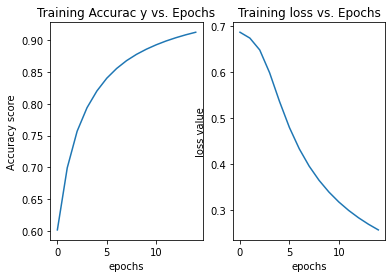

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(np.arange(0,15),o_a)
ax[0].set_title("Training Accurac y vs. Epochs")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("Accuracy score")

ax[1].plot(np.arange(0,15), [x.item() for x in o_loss])
ax[1].set_title("Training loss vs. Epochs")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss value")

plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
model_glove_2 = CustomBiLSTM_glove(my_embedding_layer, 300,50,2,100).to(device)
optimizer_2 = torch.optim.SGD(model_glove_2.parameters(), lr=0.01)
train_glove(model_glove_2, word_to_idx, train_loader2, optimizer_2, 15)

In [ ]:
torch.save({ 'model_state_dict': model_glove.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()
            },'/content/gdrive/MyDrive/COMP 599 Project/debiased_model.pth')

In [ ]:
model_glove = CustomBiLSTM_glove(debiased_my_embedding_layer.to(device), 300,50,2,100).to(device)
optimizer = torch.optim.SGD(model_glove.parameters(), lr=0.01)

In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/COMP 599 Project/debiased_model.pth')
model_glove.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
#evaluation fns for CustomBiLSTM_glove
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
def evaluate_glove(model, loader, w2i):
  model.eval()
  score = 0
  precision = 0
  recall = 0
  f1 = 0
  n = 0
  for entry in loader:
    X_tokens = tokenize_list(entry[:][0])

    #padding step
    idx = sentences_to_idx(X_tokens, w2i)

    padded_idx, lengths = padding_sentences(idx)

    #print((padded_idx).size())
    #print(len(lengths))
    
    predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

    #print(predictions)

    predictions = predictions.round()

    true_labels = one_hot(torch.tensor(entry[:][1]).to(device),num_classes = 2).float()

    #print(predictions)
    #print(true_labels)

    curr_precision, curr_recall, curr_f1, curr_support = precision_recall_fscore_support(predictions.cpu().detach(), true_labels.cpu().detach())

    curr_score =  accuracy_score(predictions.cpu().detach(), true_labels.cpu().detach())
    # print("updating score...")
    # print(curr_score)

    score += curr_score
    precision += curr_precision
    recall += curr_recall
    f1 += curr_f1

    n += 1

  return score/n, precision/n, recall/n, f1/n

def predict_glove(model, sentences, w2i):
  model.eval()

  X_tokens = tokenize_list(sentences)

  #padding step
  idx = sentences_to_idx(X_tokens, w2i)

  padded_idx, lengths = padding_sentences(idx)

  #print((padded_idx).size())
  #print(len(lengths))
  
  predictions = model.forward(padded_idx.type(torch.LongTensor).to(device), lengths)

  #print(predictions.size())

  #print(predictions)

  return torch.argmax(predictions, dim=1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
valid_results = evaluate_glove(model_glove,valid_loader2, word_to_idx)
# for item in valid_loader2:
#   print((item[0][0]))
#   print(predict_glove(model_glove,[item[0][0]], word_to_idx))
#   print(item[1][0])
#   break

In [ ]:
print("Accuracy:")
print(valid_results[0])
print("precision,recall,f1")
from statistics import mean
for i in range(1,4):
  print(mean(valid_results[i]))

Accuracy:
0.964645127118644
precision,recall,f1
0.9648438756030671
0.9646590034284325
0.9640900467311277


In [ ]:
import torch.nn.functional as F
from typing import Union, Callable
def cosine_similarity(a: np.array, b: np.array) -> float:
    # TODO: your work here
    a_tensor = torch.from_numpy(a)
    b_tensor = torch.from_numpy(b)
    return (F.cosine_similarity(a_tensor,b_tensor,0).item())


def compute_direct_bias(
    words: "list[str]",
    word_to_embedding: "dict[str, np.array]",
    gender_subspace: np.array,
    c: float = 0.25,
):
    # TODO: your work here
    word_emb = list()
    for word in words:
        word_emb.append(word_to_embedding[word])
    
    cos_list = list()
    for i in range(gender_subspace.shape[0]):
        for j in range(len(word_emb)):
            cos = cosine_similarity(word_emb[j],gender_subspace[i])
            cos_list.append(cos)
    
    abs_cos_list = [pow(abs(ele),c) for ele in cos_list]
    sum_cos = sum(abs_cos_list)
    direct_bias = sum_cos/len(words)
    return direct_bias


def weat_association(
    w: str, A: "list[str]", B: "list[str]", word_to_embedding: "dict[str, np.array]"
) -> float:
    # TODO: your work here
    w_emb = word_to_embedding[w]
    A_emb = list()
    B_emb = list()
    for word in A:
        A_emb.append(word_to_embedding[word])
    for word in B:
        B_emb.append(word_to_embedding[word])
    
    mean_cos_a = np.mean([cosine_similarity(w_emb,att_emb) for att_emb in A_emb])
    mean_cos_b = np.mean([cosine_similarity(w_emb,att_emb) for att_emb in B_emb])
    weat = mean_cos_a - mean_cos_b

    return weat


def weat_differential_association(
    X: "list[str]",
    Y: "list[str]",
    A: "list[str]",
    B: "list[str]",
    word_to_embedding: "dict[str, np.array]",
    weat_association_func: Callable,
) -> float:
    # TODO: your work here

    diff_association_x = np.sum([weat_association_func(i,A,B,word_to_embedding) for i in X]) 
    diff_association_y = np.sum([weat_association_func(i,A,B,word_to_embedding) for i in Y])

    diff_association = diff_association_x - diff_association_y 
    
    return diff_association

In [ ]:
from sklearn.decomposition import PCA
def compute_political_subspace(
    word_to_embedding: "dict[str, np.array]",
    political_attribute_words: "list[list[str, str]]",
    n_components: int = 1,
) -> np.array:
    pol_emb = list() 
    for x in political_attribute_words:
        pol_emb.append([word_to_embedding[x[0]],word_to_embedding[x[1]]])
    for l in pol_emb:
        mean = (l[0]+l[1])/2
        l[0] = l[0] - mean
        l[1] = l[1] - mean
    pol_emb = np.array(pol_emb)
    pol_emb = pol_emb.reshape(-1, pol_emb.shape[-1])
    pca = PCA(n_components)
    pca.fit(pol_emb)
    return pca.components_

In [ ]:
neutral_words = ['politician' , 'diplomat', 'president' , 'senator' , 'centrist' , 'moderate']

In [ ]:
compute_direct_bias(neutral_words, debiased_embeddings, political_subspace)

7.796121768326942e-05

In [ ]:
x = np.array([0.97447698, 0.96464767])
y = np.array([0.96325593, 0.97419243])
z = np.array([0.96838294, 0.96898926])
print(np.mean(x),np.mean(y),np.mean(z))

0.9695623250000001 0.9687241799999999 0.9686861
